In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import invgamma
import scipy.integrate as integrate
import scipy.optimize as opt
import emcee
import corner

In [57]:
# read the supernova (cosmological) redshift data
datafile = open('SCPUnion2.1_mu_vs_z.txt','r')
SCP_data = pd.read_table(datafile,comment='#',
                        names=['SN name','Redshift','Distance modulus',
                                   'Distance modulus error','P low mass'])
print(SCP_data)

    SN name  Redshift  Distance modulus  Distance modulus error  P low mass
0    1993ah  0.028488         35.346583                0.223906    0.128419
1    1993ag  0.050043         36.682368                0.166829    0.128419
2     1993o  0.052926         36.817691                0.155756    0.128419
3     1993b  0.070086         37.446737                0.158467    0.128419
4    1992bs  0.062668         37.483409                0.156099    0.128419
..      ...       ...               ...                     ...         ...
575   D-000  1.017000         44.293971                0.171046    0.000015
576   D-006  1.315000         44.971358                0.187509    0.551672
577   P-009  0.821000         43.640939                0.194014    0.551672
578   R-012  1.215000         45.246521                0.560317    0.000148
579   Z-005  0.623000         42.514524                0.241428    0.551672

[580 rows x 5 columns]


In [58]:
filename = 'SCPUnion2.1_mu_vs_z.txt'

# Load the data from the file
data = np.loadtxt(filename, usecols=(1, 2, 3, 4), skiprows = 5)
Nd = 580
c = 299792.458
alpha = 0.121851859725
beta = 2.46569277393

z = data[:, 0] # size: 580x1
low = z < 0.5
mu = data[:, 1]
mu_error = data[:, 2]
P_low_mass = data[:, 3]
dl = 10**(mu/5-5)
dl_error = 10**(mu/5-5)*(10**(mu_error/5) - 1)

low_z = z[low] # size: 412x1
low_mu = mu[low]
low_mu_error = mu_error[low]
low_P_low_mass = P_low_mass[low]
low_dl = 10**(low_mu/5-5)
low_dl_error = dl_error[low]

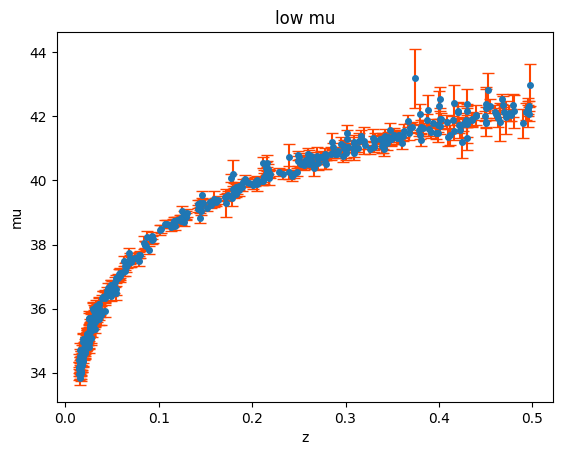

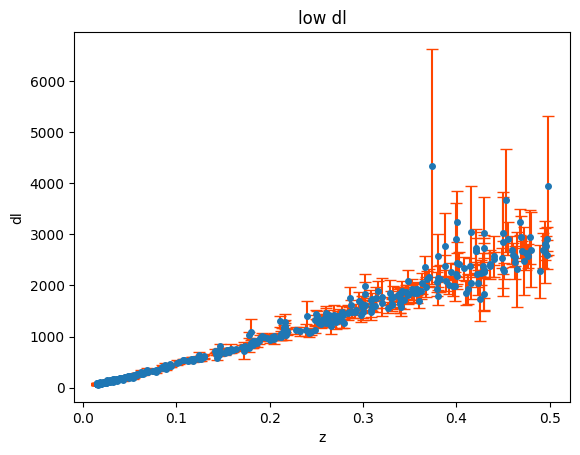

In [4]:
plt.figure(1)
plt.errorbar(low_z, low_mu, yerr=low_mu_error, fmt='o', ecolor='orangered', capsize=4, linestyle='None', markersize=4)
plt.xlabel('z')
plt.ylabel('mu')
plt.title('low mu')

plt.show()

plt.figure(2)
plt.errorbar(low_z, low_dl, yerr=low_dl_error, fmt='o', ecolor='orangered', capsize=4, linestyle='None', markersize=4)
plt.xlabel('z')
plt.ylabel('dl')
plt.title('low dl')

plt.show()

In [21]:
# Normerade vikter.
W = np.square(1/low_dl_error)
Nw = np.sum(W)/Nd
W = W/Nw

In [6]:
def dl_model(H0, q0, z):
    return c / H0 * (z + 0.5 * (1-q0) * z**2)

In [25]:
def log_likelihood(param, z, dl, W):
    H0, q0, sig2 = param
    n = len(dl)
    return -0.5 * (np.sum((dl - dl_model(H0, q0, z))**2 * W / sig2)) - (n/2)*np.log(sig2* 2*np.pi)

def log_prior(sig2):
    if sig2 > 1e-16:
        return invgamma.logpdf(sig2, a = alpha, scale = beta) 
    else:
        return -np.inf

def log_posterior(param, z, dl, W):
    lp = log_prior(param[-1])
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(param, z, dl, W)
    return ll + lp

In [8]:
def simple_mcmc_analysis(sampler, par, label, burn_in):

    print(f'Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):0.3f}')
    # discard the first 'burn_in' samples 
    
    # thinning means that you only keep every nth sample. E.g. thinning=10 -> keep every 10th sample.
    # This can be useful for reducing long autocorrelation lenghts in a chain. However, thinning is expensive.
    # A thinned chain must be run E.g. 10x longer to reach the desired number of samples.
    # One can argue that thinning is not an advantageous strategy. So keep thinning = 1
    thinning = 1
    flat_mcmc_samples = sampler.get_chain(discard=burn_in,thin=thinning, flat=True)
    print(f'Discarding {nwalkers*burn_in} steps as burn-in')
    print(f'Chain length:{len(flat_mcmc_samples)}')

    fig1 = plt.figure();
    plt.plot(flat_mcmc_samples[:,par],color='gray',alpha=0.7)
    plt.xlabel('Sample');
    plt.ylabel(label)
    plt.xlim(0,len(flat_mcmc_samples));

    return flat_mcmc_samples

In [26]:
ndim, nwalkers = 3, 40
start_pos = [70, -0.4, 251] + 1e-3 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(low_z, low_dl, W))
sampler.run_mcmc(start_pos, 4000, progress=True)

100%|███████████████████████████████████████████████████████████████| 4000/4000 [00:10<00:00, 371.38it/s]


State([[ 6.97323300e+01 -2.57452952e-01  2.73591849e+02]
 [ 6.99669298e+01 -3.64167602e-01  2.67692791e+02]
 [ 6.98428044e+01 -3.11434680e-01  2.49053827e+02]
 [ 7.03335235e+01 -4.65985644e-01  2.71401217e+02]
 [ 7.00049498e+01 -2.81599817e-01  2.53501703e+02]
 [ 7.05133195e+01 -4.60598822e-01  2.72345353e+02]
 [ 7.06529407e+01 -4.77286175e-01  2.74542015e+02]
 [ 6.95220258e+01 -3.22023809e-01  2.46189137e+02]
 [ 7.02349850e+01 -4.39377805e-01  2.34763934e+02]
 [ 7.04781669e+01 -4.03221605e-01  2.37201012e+02]
 [ 7.13727093e+01 -5.65905906e-01  2.57093429e+02]
 [ 7.05797279e+01 -4.39402180e-01  2.23976410e+02]
 [ 7.00267865e+01 -3.95368706e-01  2.77267801e+02]
 [ 7.03916231e+01 -3.76159652e-01  2.71146495e+02]
 [ 7.03129409e+01 -4.23687437e-01  2.22874437e+02]
 [ 7.06183970e+01 -4.79837990e-01  2.30203736e+02]
 [ 7.01998640e+01 -4.00763972e-01  2.35795563e+02]
 [ 7.04079938e+01 -4.27316416e-01  2.80156775e+02]
 [ 6.99284571e+01 -3.93858268e-01  2.57187256e+02]
 [ 7.05007431e+01 -4.3887

Mean acceptance fraction: 0.647
Discarding 20000 steps as burn-in
Chain length:140000


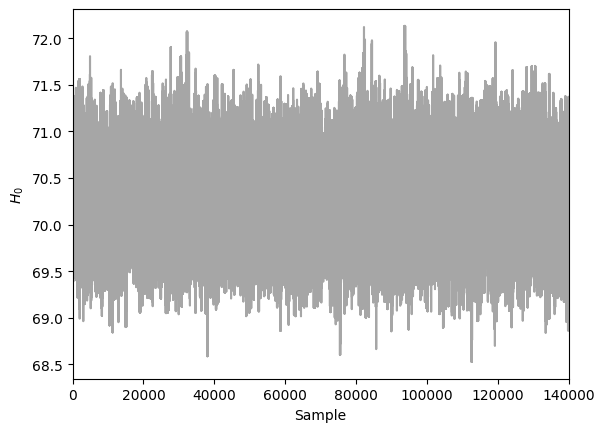

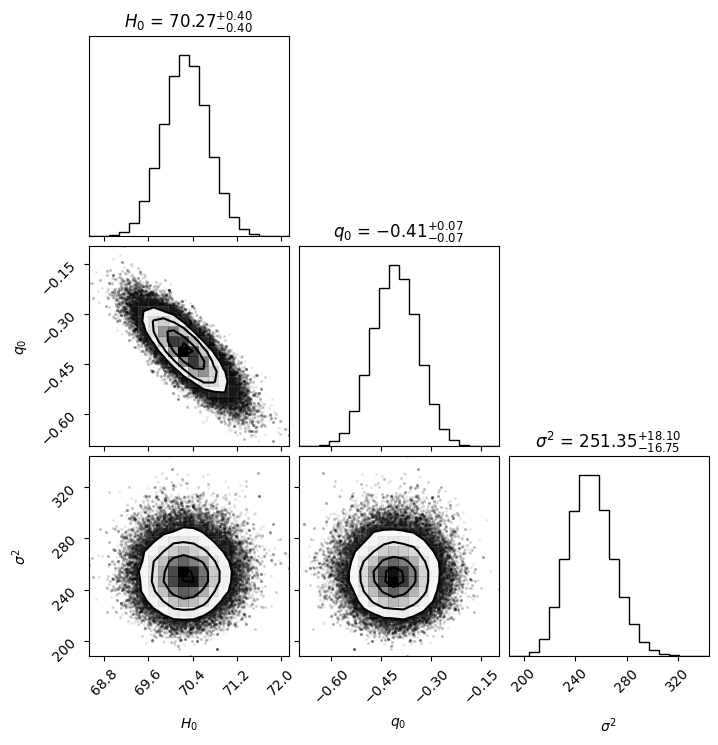

In [27]:
flat_mcmc_samples = simple_mcmc_analysis(sampler, par=0, label=f'$H_0$', burn_in=500)

fig = corner.corner(flat_mcmc_samples,labels=[r"$H_0$", r"$q_0$", r"$\sigma^2$"],show_titles=True)

In [28]:
# medelvärden
H0_mean, q0_mean, sig2_mean = np.array([np.mean(flat_mcmc_samples[:,k]) for k in range(0,len(flat_mcmc_samples[0]))])

H0 = flat_mcmc_samples[:,0]
q0 = flat_mcmc_samples[:,1]
sig2 = flat_mcmc_samples[:,2]

z_lin = np.linspace(0,0.5, 1000)
res_d = np.empty(1000)
res_d_min = np.empty(1000)
res_d_max = np.empty(1000)
for i,z in enumerate(z_lin):
    vec = dl_model(H0, q0, z)
    res_d[i] = np.mean(vec)
    res_d_min[i] = np.percentile(vec, 5)
    res_d_max[i] = np.percentile(vec,95)

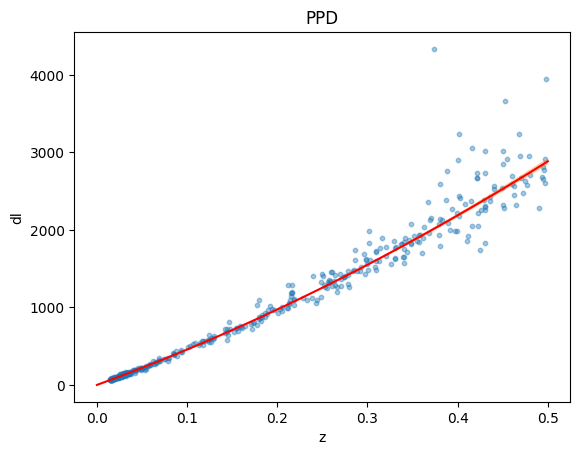

In [29]:
plt.figure(3)
plt.scatter(low_z, low_dl, s=10, alpha=0.4)
plt.plot(z_lin, res_d, c='r')
plt.fill_between(z_lin, res_d_min, res_d_max, alpha = 0.4)
plt.xlabel('z')
plt.ylabel('dl')
plt.title('PPD')

plt.show()

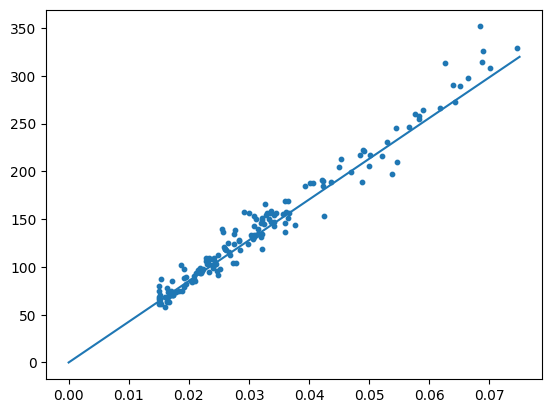

In [30]:
lower_z = low_z[low_z < 0.075]
lower_dl = low_dl[low_z < 0.075]
z_lower_lin = np.linspace(0, 0.075, 500)

plt.figure(4)
plt.scatter(lower_z, lower_dl, s=10)
plt.plot(z_lower_lin, z_lower_lin*c/H0_mean)

In [14]:
# Task 2

In [94]:
H0 = 70

def E_wCDM(z, Omega_M0, w):
    return Omega_M0*(1+z)**3 + (1-Omega_M0)*(1+z)**(3*(1+w))

def E_LCDM(z, Omega_M0, w):
    return Omega_M0*(1+z)**3 + (1-Omega_M0)

In [109]:
def neg_log_likelihood_two(params, model, z, dl, dl_error):
    if model == 'LCDM':
        Omega_M = params[0]
        theoretical_dl = dl_model(E_LCDM, z, Omega_M)
    elif model == 'wCDM':
        Omega_M, w = params
        theoretical_dl = dl_model(E_wCDM, z, Omega_M, w)

    residuals = (dl - theoretical_dl) ** 2
    weights = 1 / dl_error ** 2
    return 0.5 * np.sum(residuals * weights) + 0.5*(np.log(2*np.pi)*n + np.sum(2*np.log(W)) )

In [108]:
def dl_model(E_function, z, Omega_M, w=None):
    dl_values = np.zeros_like(z)
    c = 299792.458
    H0 = 70

    for i, z_i in enumerate(z):
        integral, _ = integrate.quad(lambda z: 1 / E_function(z, Omega_M, w), 0, z_i)
        dl_values[i] = c * (1 + z_i) / H0 * integral

    return dl_values

In [110]:
# Fit ΛCDM Model
initial_guess_LCDM = [0.5]  # Initial guess for Omega_M
result_LCDM = opt.minimize(neg_log_likelihood, initial_guess_LCDM, args=('LCDM', z, dl, dl_error))
aic_lcdm = 2 * len(initial_guess_LCDM) - 2 * (-result_LCDM.fun)
bic_lcdm = len(initial_guess_LCDM) * np.log(len(z)) - 2 * (-result_LCDM.fun)

# Fit wCDM Model
initial_guess_wCDM = [0.5, -1]  # Initial guesses for Omega_M and w
result_wCDM = opt.minimize(neg_log_likelihood, initial_guess_wCDM, args=('wCDM', z, dl, dl_error))
aic_wcdm = 2 * len(initial_guess_wCDM) - 2 * (-result_wCDM.fun)
bic_wcdm = len(initial_guess_wCDM) * np.log(len(z)) - 2 * (-result_wCDM.fun)

# Output Results
print(f"AIC for ΛCDM: {aic_lcdm}, BIC for ΛCDM: {bic_lcdm}")
print(f"AIC for wCDM: {aic_wcdm}, BIC for wCDM: {bic_wcdm}")

AIC for ΛCDM: 31569.154663485737, BIC for ΛCDM: 31573.517691589277
AIC for wCDM: 27233.3758527249, BIC for wCDM: 27242.10190893198
